# Detekcija i prepoznavanje registarskih tablica (YOLO + OCR)

Cilj ovog projekta je da se kombinuje **YOLOv11m model** za detekciju tablica i **OCR sistemi** (PaddleOCR i Tesseract)
kako bi se automatski prepoznali tekstovi na registarskim tablicama iz slika.

## Glavne komponente:
- YOLOv11m model za detekciju tablica
- PaddleOCR i Tesseract za prepoznavanje teksta
- Preprocessing za poboljšanje čitljivosti tablica
- Tkinter GUI za demonstraciju uživo


### Treniranje YOLO modela

Koristimo **YOLOv11m** model kao bazu za detekciju registarskih tablica.  
Dataset je anotiran u **Label Studio**: svaka tablica je obeležena bounding box-om i izvezen u **YOLO format**.  

In [ ]:
import torch
from ultralytics import YOLO

yaml = "datasets/license_plates_srb/plate_recognition_dataset_srb.yaml"
model = YOLO("models/yolo/yolo11m.pt", task="detect")

model.train(
    data=yaml,
    epochs=30,
    patience=5,
    augment=True,
    imgsz=640,
    batch=1,
    name="plate_recognition",
    save=True,
    cache=True,
    device="cuda" if torch.cuda.is_available() else "cpu"
)


## Evaluacija treniranja YOLO modela

Model je treniran koristeći **transfer learning**: preuzet je YOLOv11m težinski model (`.pt`) i finetuniran na našem dataset-u kroz **30 epoha**, sa augmentacijom i automatskim prekidom treniranja (patience=5).  

Nakon treniranja, model je evaluiran pomoću:

- **Precision / Recall**: koliko model tačno detektuje tablice i koliko detekcija je ispravna.  
- **mAP@0.5 i mAP@0.5:0.95**: metričke vrednosti koje pokazuju kvalitet detekcije, uključujući i precizno pozicioniranje bounding box-ova.  
- **Gubitak tokom treniranja (loss curves)**: vizuelizuje se da se prati konvergencija modela.  

Cilj evaluacije je identifikovati najbolju kombinaciju **YOLO modela, varijante augmentacije** i **OCR sistema** za čitanje registarskih tablica.

Best epoch: 21


metrics/mAP50(B)        0.99500
metrics/precision(B)    0.95369
metrics/recall(B)       1.00000
metrics/mAP50-95(B)     0.67538
Name: 21, dtype: float64

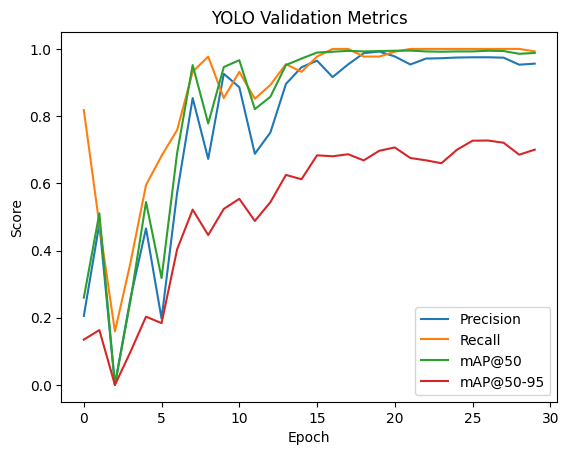

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("models/yolo/yolo11m_plates_srb_large.pt_results.csv")

display_metrics = ["metrics/mAP50(B)", "metrics/precision(B)", "metrics/recall(B)", "metrics/mAP50-95(B)"]
best_epoch = df["metrics/mAP50(B)"].idxmax()
best_values = df.loc[best_epoch][display_metrics]

print(f"Best epoch: {best_epoch}")
display(best_values)

plt.plot(df["metrics/precision(B)"], label="Precision")
plt.plot(df["metrics/recall(B)"], label="Recall")
plt.plot(df["metrics/mAP50(B)"], label="mAP@50")
plt.plot(df["metrics/mAP50-95(B)"], label="mAP@50-95")
plt.title("YOLO Validation Metrics")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.show()

## Poređenje YOLO modela

,Precision,Recall,mAP@0.5,mAP@0.5:0.95
YOLO11m SRB,0.9743,0.9333,0.9850,0.5787
YOLO11m SRB Mid,0.9280,0.8596,0.9622,0.5850
YOLO11m SRB Large,0.9955,1.0000,0.9950,0.7629


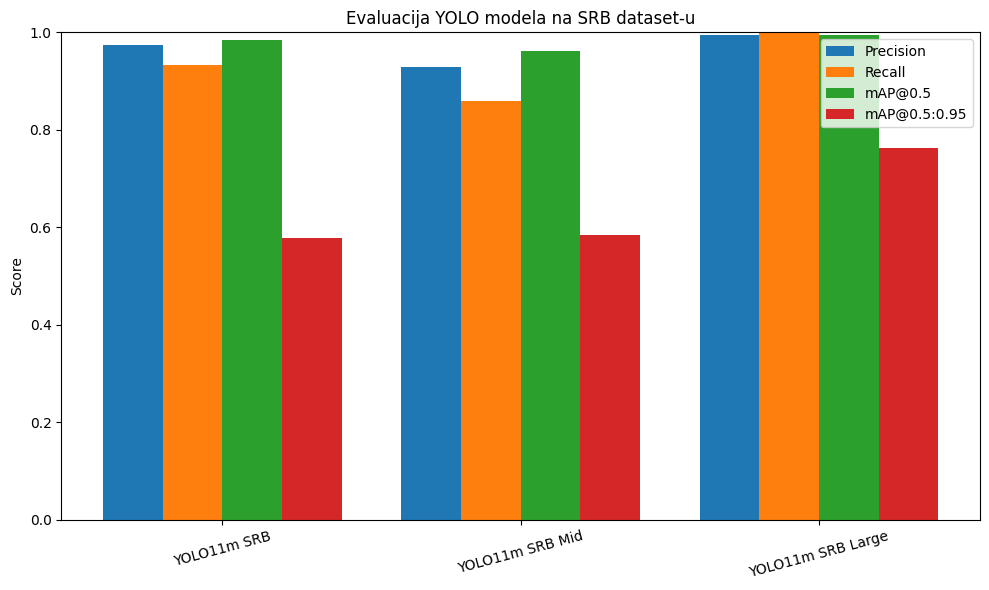

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from eval.eval_yolo import evaluate_yolo_models

# data = evaluate_yolo_models()
data = {
    "YOLO11m SRB": {"Precision": 0.9743, "Recall": 0.9333, "mAP@0.5": 0.9850, "mAP@0.5:0.95": 0.5787},
    "YOLO11m SRB Mid": {"Precision": 0.9280, "Recall": 0.8596, "mAP@0.5": 0.9622, "mAP@0.5:0.95": 0.5850},
    "YOLO11m SRB Large": {"Precision": 0.9955, "Recall": 1.0000, "mAP@0.5": 0.9950, "mAP@0.5:0.95": 0.7629}
}

df = pd.DataFrame(data).T
df = df[["Precision", "Recall", "mAP@0.5", "mAP@0.5:0.95"]]
display(df)

metrics = df.columns
x = np.arange(len(df))
width = 0.2

fig, ax = plt.subplots(figsize=(10,6))
for i, metric in enumerate(metrics):
    ax.bar(x + i*width, df[metric], width, label=metric)

ax.set_xticks(x + width*1.5)
ax.set_xticklabels(df.index, rotation=15)
ax.set_ylim(0, 1)
ax.set_ylabel("Score")
ax.set_title("Evaluacija YOLO modela na SRB dataset-u")
ax.legend()
plt.tight_layout()
plt.show()


### Zaključak o YOLO modelima

- **YOLO11m SRB Large** je najbolji model:
  - Recall = 1.0 → detektuje sve tablice
  - Precision = 0.9955 → gotovo sve predikcije tačne
  - mAP@0.5 = 0.9950 → odlična generalna detekcija
  - mAP@0.5:0.95 = 0.7629 → pozicioniranje bounding box-a bolje nego kod drugih varijanti

- **YOLO11m SRB i YOLO11m SRB Mid**:
  - Niži Precision i Recall (~0.86–0.97)
  - mAP niži → pozicioniranje i robustnost slabiji

**Zaključak:** Za visoku tačnost detekcije tablica preporučuje se **YOLO11m SRB Large**. Ostale varijante su pogodne za brze testove ili manje zahtevne scenarije.

## Detekcija tablice sa YOLO modelom

C:\Users\Luka\AppData\Local\Programs\Python\Python312\Lib\ssl.py:524: UserWarning: Bad certificate in Windows certificate store: not enough data: cadata does not contain a certificate (_ssl.c:4014)
  warnings.warn(f"Bad certificate in Windows certificate store: {exc!s}")


image 1/1 c:\Users\Luka\Documents\1.MojDocuments\Fakultet\6.SEMESTAR\Racunarska inteligencija\projekat\license-plate-detection\datasets\pipeline\test\7fb1311f-e5dc2fd30a2e-1920x1080.jpg: 640x608 1 license_plate, 798.3ms
Speed: 9.4ms preprocess, 798.3ms inference, 14.0ms postprocess per image at shape (1, 3, 640, 608)


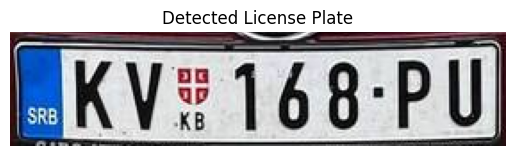

In [7]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
from torch import cuda

model = YOLO("models/yolo/yolo11m_plates_srb_large.pt")

image_path = "datasets/pipeline/test/7fb1311f-e5dc2fd30a2e-1920x1080.jpg"
results = model.predict(image_path, conf=0.25, iou=0.45, device="cuda" if cuda.is_available() else "cpu")
results[0].show()

box = results[0].boxes[0]
x1, y1, x2, y2 = map(int, box.xyxy[0].cpu().numpy())
cv_img = cv2.imread(image_path)
plate_crop = cv_img[y1:y2, x1:x2]

plt.imshow(cv2.cvtColor(plate_crop, cv2.COLOR_BGR2RGB))
plt.title("Detected License Plate")
plt.axis("off")
plt.show()


## Poboljšanje slike (preprocessing)

Pre nego što se primeni OCR na registarske tablice, slike se dodatno obrađuju kako bi se poboljšala čitljivost karaktera. Ovaj proces uključuje:

1. **Cropped image** – tablica se seče iz originalne slike prema detektovanom bounding box-u.
2. **Grayscale konverzija** – originalna slika se pretvara u sivu skalu radi lakšeg procesiranja.
3. **CLAHE (Contrast Limited Adaptive Histogram Equalization)** – lokalno poboljšava kontrast slike kako bi tablica bila bolje vidljiva.
4. **Denoising** – uklanjanje šuma uz očuvanje ivica, koristeći bilateralni filter.
5. **Adaptive thresholding / Binarization** – konverzija u crno-belu sliku, gde karakteri postaju tamni a pozadina svetla.
6. **Morfološka obrada** – uklanjanje sitnog šuma (opening).
7. **Sharpening / Unsharp masking** – dodatno naglašava ivice karaktera.
8. **Black pixel masking (advanced)** – čuva samo tamne (crne) piksele i uklanja sve ostale za bolju detekciju karaktera.
9. **Resize** – skaliranje slike na standardnu širinu radi unifikacije za OCR modele.

Postoje dve varijante poboljšanja:

- **Basic enhancement**: standardni proces sa CLAHE, denoising, binarizacijom i sharpeningom.
- **Advanced enhancement**: dodatni koraci sa maskiranjem tamnih piksela, sofisticiranijim denoisingom i prilagođenim sharpenom, što poboljšava čitljivost znakova na tablici.

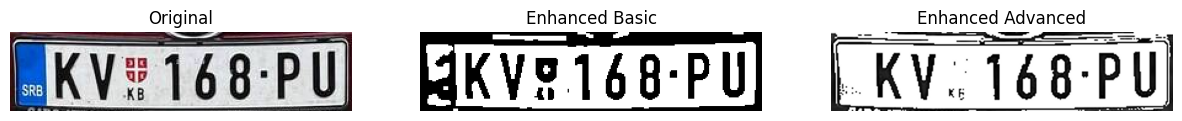

In [8]:
from helpers.img_utils import enhance_photo, enhance_photo_advanced

enhanced_basic = enhance_photo(plate_crop)
enhanced_advanced = enhance_photo_advanced(plate_crop)

variants = {
    "Original": plate_crop,
    "Enhanced Basic": enhanced_basic,
    "Enhanced Advanced": enhanced_advanced
}

fig, ax = plt.subplots(1,3, figsize=(15,5))
for i, (title, img) in enumerate(variants.items()):
    ax[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[i].set_title(title)
    ax[i].axis("off")
plt.show()

## Predikcije pomoću OCR (PaddleOCR i Tesseract)

In [12]:
from paddleocr import PaddleOCR
import re

ocr = PaddleOCR(
            text_detection_model_dir=None,
            text_recognition_model_dir=None,
            lang='en',
            text_det_box_thresh=0.5,
            use_textline_orientation=True
        )
print("=== PaddleOCR Results ===")
for name, img in variants.items():
    results = ocr.predict(img, use_textline_orientation=True)
    rec_texts = results[0]['rec_texts']
    rec_scores = results[0]['rec_scores']

    cleaned_texts = [
        re.sub(r'[^A-Z0-9]', '', text.upper())
        for text, score in zip(rec_texts, rec_scores) if score > 0.6
    ]

    combined = ''.join(cleaned_texts)

    match = re.search(r'([A-Z]{2})(\d{3,5})([A-Z]{2})', combined)
    print(f"{name} OCR: {match.group(0) if match else 'No valid plate found'}")

Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\Luka\.paddlex\official_models\PP-LCNet_x1_0_doc_ori`.
Creating model: ('UVDoc', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\Luka\.paddlex\official_models\UVDoc`.
Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\Luka\.paddlex\official_models\PP-LCNet_x1_0_textline_ori`.
Creating model: ('PP-OCRv5_server_det', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\Luka\.paddlex\official_models\PP-OCRv5_server_det`.
Creating model: ('en_PP-OCRv5_mobile_rec', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\Luka\.paddlex\offic

=== PaddleOCR Results ===
Original OCR: KV168PU
Enhanced Basic OCR: KV168PU
Enhanced Advanced OCR: KV168PU


In [13]:
import pytesseract
from PIL import Image
import re

pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
config = r'--oem 3 --psm 8 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZČĆŽŠĐ0123456789'

print("=== Tesseract Results ===")
for name, img in variants.items():
    predict = pytesseract.image_to_data(img, lang='srp_latn', config=config, output_type=pytesseract.Output.DICT)
    
    texts = []
    
    for text, conf in zip(predict['text'], predict['conf']):
        try:
            conf = float(conf)
        except ValueError:
            conf = -1
        if conf >= 0:
            cleaned = re.sub(r'[^A-Z0-9ČĆŽŠĐ]', '', text.upper())
            if cleaned:
                texts.append(cleaned)
                
    combined = ''.join(texts)

    match = re.search(r'([A-ZČĆŽŠĐ]{2})(\d{3,5})([A-ZČĆŽŠĐ]{2})', combined)
    print(f"{name}: {match.group(0) if match else combined}")


=== Tesseract Results ===
Original: VS168PU
Enhanced Basic: KVS16BPU
Enhanced Advanced: KV168PU


## Analiza OCR performansi

Analiza performansi OCR sistema vrši se na dva nivoa:

- **Char Accuracy (karakteri)**: procenat pravilno prepoznatih karaktera u odnosu na ukupno očekivane karaktere na tablici.  
- **Plate Accuracy (tablice)**: procenat tablica koje su u potpunosti ispravno prepoznate.  

Ovaj pristup omogućava detaljniju evaluaciju kako preciznosti pojedinačnih karaktera, tako i uspešnosti celokupnog čitanja registarskih tablica.

,OCR,Enhancement,Char Accuracy,Plate Accuracy
0,PaddleOCR,No,0.5607,0.1333
1,PaddleOCR,Basic,0.4953,0.1333
2,PaddleOCR,Advanced,0.5607,0.1333
3,Tesseract,No,0.4393,0.1333
4,Tesseract,Basic,0.1495,0.0000
5,Tesseract,Advanced,0.4393,0.1333


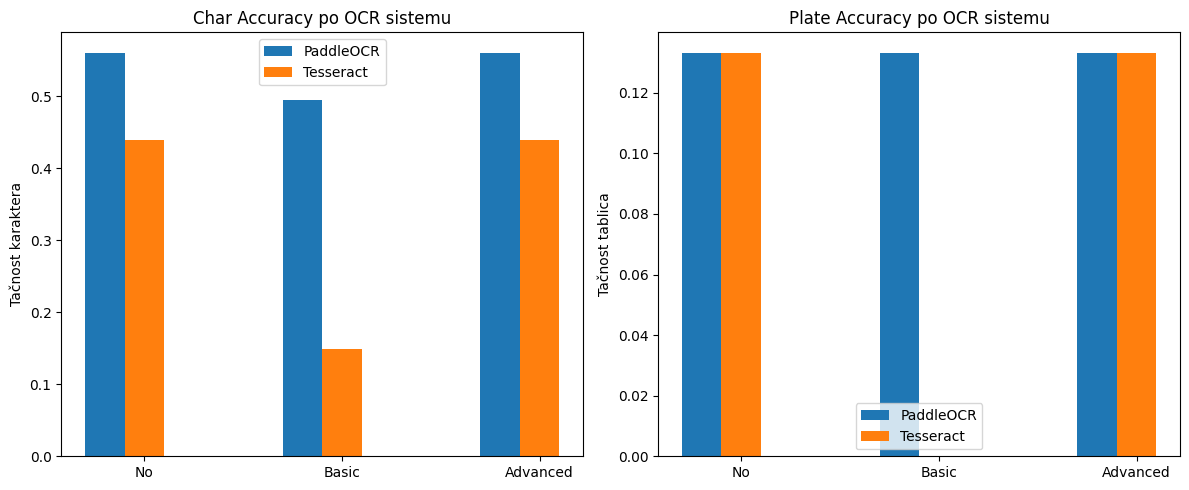

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from eval.eval_ocrs import evaluate_ocrs

# data = evaluate_ocrs()
data = {
    'PaddleOCR No Enhancement': (0.5607, 0.1333),
    'PaddleOCR Basic Enhancement': (0.4953, 0.1333),
    'PaddleOCR Advanced Enhancement': (0.5607, 0.1333),
    'Tesseract No Enhancement': (0.4393, 0.1333),
    'Tesseract Basic Enhancement': (0.1495, 0.0),
    'Tesseract Advanced Enhancement': (0.4393, 0.1333)
}

df = pd.DataFrame(
    [(k, v[0], v[1]) for k, v in data.items()],
    columns=["Model", "Char Accuracy", "Plate Accuracy"]
)

df["OCR"] = df["Model"].apply(lambda x: x.split()[0])
df["Enhancement"] = df["Model"].apply(lambda x: x.split()[1])
df = df.drop(columns="Model")
df = df[["OCR", "Enhancement", "Char Accuracy", "Plate Accuracy"]]
display(df)

enhancements = ["No", "Basic", "Advanced"]
x = range(len(enhancements))

fig, axes = plt.subplots(1, 2, figsize=(12,5))

for ocr in df["OCR"].unique():
    subset = df[df["OCR"]==ocr]
    axes[0].bar(
        [i + 0.2*list(df["OCR"].unique()).index(ocr) for i in x],
        subset["Char Accuracy"],
        width=0.2,
        label=ocr
    )
axes[0].set_xticks([i+0.2 for i in x])
axes[0].set_xticklabels(enhancements)
axes[0].set_title("Char Accuracy po OCR sistemu")
axes[0].set_ylabel("Tačnost karaktera")
axes[0].legend()

for ocr in df["OCR"].unique():
    subset = df[df["OCR"]==ocr]
    axes[1].bar(
        [i + 0.2*list(df["OCR"].unique()).index(ocr) for i in x],
        subset["Plate Accuracy"],
        width=0.2,
        label=ocr
    )
axes[1].set_xticks([i+0.2 for i in x])
axes[1].set_xticklabels(enhancements)
axes[1].set_title("Plate Accuracy po OCR sistemu")
axes[1].set_ylabel("Tačnost tablica")
axes[1].legend()

plt.tight_layout()
plt.show()


## Zaključak OCR performansi

- **PaddleOCR** generalno bolje prepoznaje karaktere od Tesseract-a.  
- **Enhancement** ima nepredvidiv efekat: Basic ponekad smanjuje tačnost, Advanced obično vraća ili poboljšava performanse.  
- **Plate accuracy** je niska za sve kombinacije, što pokazuje da kompletno prepoznavanje tablica i dalje predstavlja izazov.  

**Zaključak:** PaddleOCR je pouzdaniji za karaktere, dok unapređenje slike daje umeren efekat; Tesseract je manje stabilan.


## Analiza pipeline-a

Analiza pipeline-a se sprovodi evaluacijom celog lanca: detekcija tablica (YOLO) → unapređenje slike → OCR.  
Performanse se prate kroz **Char Accuracy** (tačnost prepoznatih karaktera) i **Plate Accuracy** (tačnost cele tablice), kako bi se identifikovale kombinacije modela, OCR sistema i unapređenja slike koje daju najbolje rezultate.


Evaluacija celog pipeline-a:


,YOLO Model,Enhancement,OCR,Char Accuracy,Plate Accuracy
0,YOLO11m Plates SRB,None,Tesseract,0.3303,0.0667
1,YOLO11m Plates SRB,None,PaddleOCR,0.7615,0.4667
2,YOLO11m Plates SRB,Basic,Tesseract,0.2752,0.1333
3,YOLO11m Plates SRB,Basic,PaddleOCR,0.5780,0.2667
4,YOLO11m Plates SRB,Advanced,Tesseract,0.5138,0.0667
5,YOLO11m Plates SRB,Advanced,PaddleOCR,0.5413,0.2667
6,YOLO11m Plates SRB Mid,None,Tesseract,0.3627,0.0000
7,YOLO11m Plates SRB Mid,None,PaddleOCR,0.5196,0.2667
8,YOLO11m Plates SRB Mid,Basic,Tesseract,0.1961,0.0667
9,YOLO11m Plates SRB Mid,Basic,PaddleOCR,0.5000,0.2667


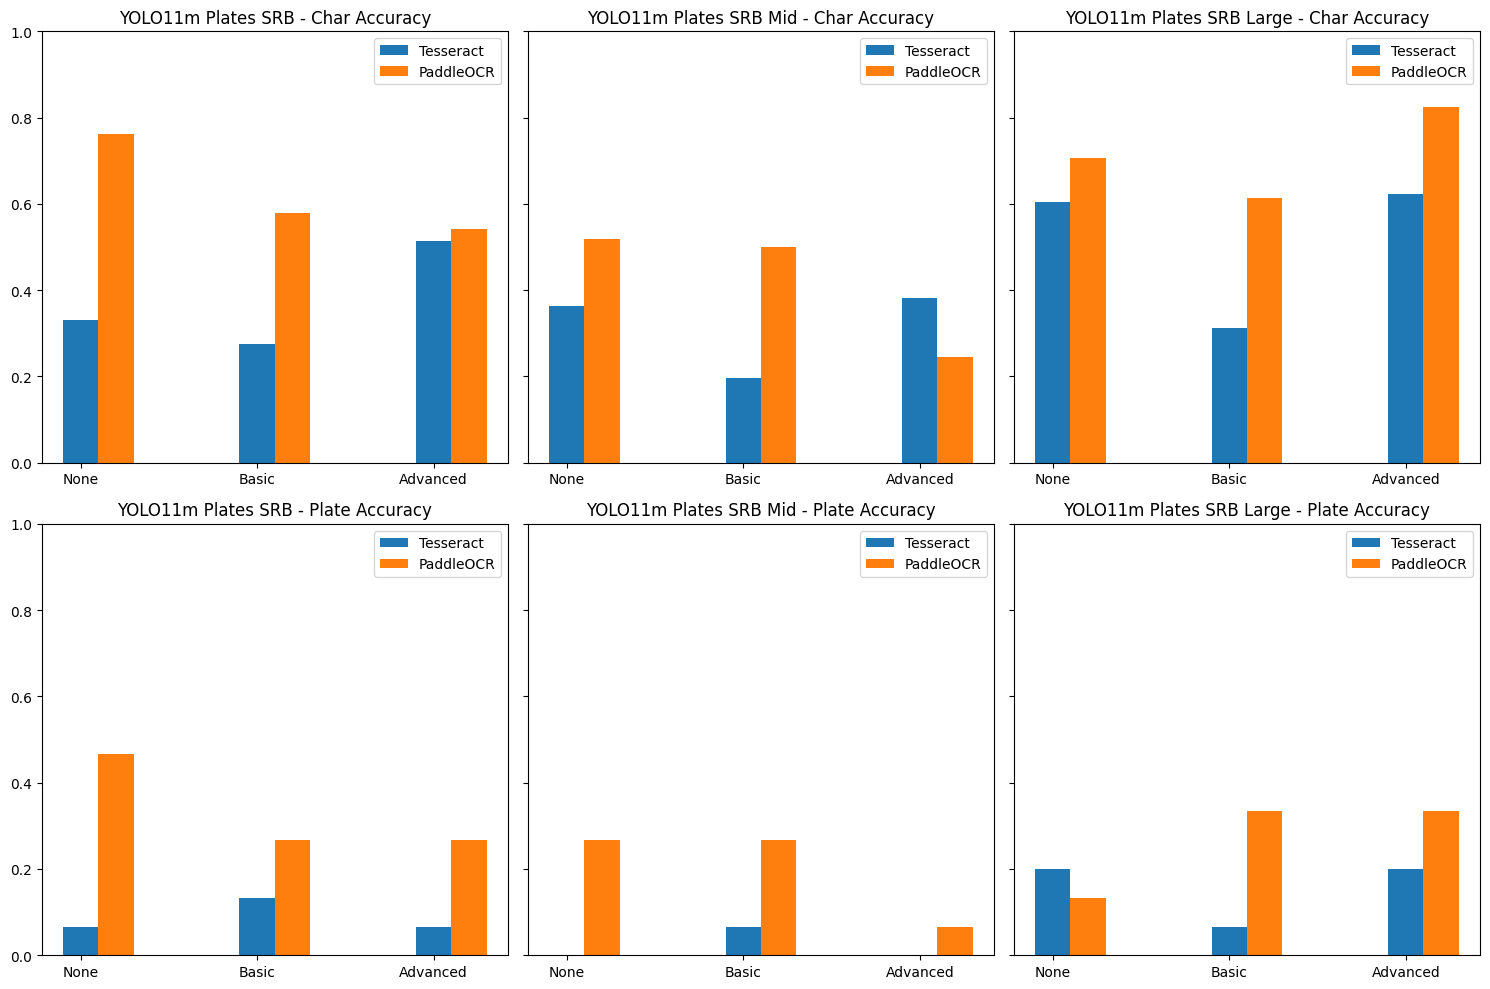

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from eval.eval_pipeline import evaluate_pipeline

# data = evaluate_pipeline()
data = {
    'YOLO11m Plates SRB + None + Tesseract': (0.3303, 0.0667),
    'YOLO11m Plates SRB + None + PaddleOCR': (0.7615, 0.4667),
    'YOLO11m Plates SRB + Basic + Tesseract': (0.2752, 0.1333),
    'YOLO11m Plates SRB + Basic + PaddleOCR': (0.5780, 0.2667),
    'YOLO11m Plates SRB + Advanced + Tesseract': (0.5138, 0.0667),
    'YOLO11m Plates SRB + Advanced + PaddleOCR': (0.5413, 0.2667),
    'YOLO11m Plates SRB Mid + None + Tesseract': (0.3627, 0.0),
    'YOLO11m Plates SRB Mid + None + PaddleOCR': (0.5196, 0.2667),
    'YOLO11m Plates SRB Mid + Basic + Tesseract': (0.1961, 0.0667),
    'YOLO11m Plates SRB Mid + Basic + PaddleOCR': (0.5000, 0.2667),
    'YOLO11m Plates SRB Mid + Advanced + Tesseract': (0.3824, 0.0),
    'YOLO11m Plates SRB Mid + Advanced + PaddleOCR': (0.2451, 0.0667),
    'YOLO11m Plates SRB Large + None + Tesseract': (0.6055, 0.2000),
    'YOLO11m Plates SRB Large + None + PaddleOCR': (0.7064, 0.1333),
    'YOLO11m Plates SRB Large + Basic + Tesseract': (0.3119, 0.0667),
    'YOLO11m Plates SRB Large + Basic + PaddleOCR': (0.6147, 0.3333),
    'YOLO11m Plates SRB Large + Advanced + Tesseract': (0.6239, 0.2000),
    'YOLO11m Plates SRB Large + Advanced + PaddleOCR': (0.8257, 0.3333),
}

df = pd.DataFrame(
    [(k, v[0], v[1]) for k, v in data.items()],
    columns=["Pipeline", "Char Accuracy", "Plate Accuracy"]
)

df["YOLO Model"] = df["Pipeline"].apply(lambda x: x.split("+")[0].strip())
df["Enhancement"] = df["Pipeline"].apply(lambda x: x.split("+")[1].strip())
df["OCR"] = df["Pipeline"].apply(lambda x: x.split("+")[2].strip())
df = df.drop(columns="Pipeline")
df = df[["YOLO Model", "Enhancement", "OCR", "Char Accuracy", "Plate Accuracy"]]

print("Evaluacija celog pipeline-a:")
display(df)

yolo_models = df["YOLO Model"].unique()
enhancements = ["None", "Basic", "Advanced"]
ocr_systems = df["OCR"].unique()

fig, axes = plt.subplots(2, len(yolo_models), figsize=(5*len(yolo_models), 10), sharey='row')

for col, yolo in enumerate(yolo_models):
    for ocr in ocr_systems:
        subset = df[(df["YOLO Model"]==yolo) & (df["OCR"]==ocr)]
        axes[0, col].bar(
            [i + 0.2*(0 if ocr=="Tesseract" else 1) for i in range(len(enhancements))],
            subset["Char Accuracy"],
            width=0.2,
            label=ocr
        )
        axes[1, col].bar(
            [i + 0.2*(0 if ocr=="Tesseract" else 1) for i in range(len(enhancements))],
            subset["Plate Accuracy"],
            width=0.2,
            label=ocr
        )
    axes[0, col].set_xticks(range(len(enhancements)))
    axes[0, col].set_xticklabels(enhancements)
    axes[0, col].set_title(f"{yolo} - Char Accuracy")
    axes[0, col].set_ylim(0, 1)
    axes[1, col].set_xticks(range(len(enhancements)))
    axes[1, col].set_xticklabels(enhancements)
    axes[1, col].set_title(f"{yolo} - Plate Accuracy")
    axes[1, col].set_ylim(0, 1)
    axes[0, col].legend()
    axes[1, col].legend()

plt.tight_layout()
plt.show()


### Zaključak o pipeline evaluaciji

Na osnovu evaluacije celog pipeline-a, možemo uočiti nekoliko ključnih trendova:

- **PaddleOCR generalno nadmašuje Tesseract** u prepoznavanju karaktera (Char Accuracy) i celih tablica (Plate Accuracy) za sve kombinacije YOLO modela i unapređenja slike.
- **Napredna unapređenja slike (Advanced Enhancement)** često poboljšavaju tačnost OCR-a, posebno kod PaddleOCR-a.
- **Veći YOLO modeli (Large)** daju bolje performanse, posebno u kombinaciji sa PaddleOCR i Advanced Enhancement.
- **Najbolja kombinacija** je `YOLO11m Plates SRB Large + Advanced + PaddleOCR`, koja postiže najvišu tačnost karaktera i relativno visoku tačnost cele tablice.

## Zaključak
- Projekat je potvrdio mogućnost razvijanja automatskog sistema za detekciju i prepoznavanje registarskih tablica.
- Glavna slaba tačka: prepoznavanje karaktera sa domaćih tablica, OCR deo sistema nije dovoljno pouzdan. 
- Sledeći korak u razvoju: obučavanje OCR modela nad tekstom sa domaćih tablica.
- Ovakvo unapređenje bi donelo značajno povećanje pouzdanosti i primenljivosti kompletnog sistema.
